## Importing dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

## Dataset

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQ1LCXS/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQ1LCXS/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Preprocessing

In [17]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask

def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [18]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

## Creating datasets

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

## Metric - **IoU**

In [6]:
def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.round(y_pred), tf.float32)

    intersection = tf.math.count_nonzero(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)))
    union = tf.math.count_nonzero(tf.add(y_true, y_pred))

    iou = intersection / union

    return iou

## U-Net model

In [20]:

def get_model(img_size=(128, 128, 3)):
    inputs = layers.Input(img_size)

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = layers.concatenate([conv3, up5], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = layers.concatenate([conv2, up6], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = layers.concatenate([conv1, up7], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(3, 1, activation='softmax')(conv7)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [21]:
model = get_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

## Callbacks

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model.h5', verbose=0, save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


## Training

In [23]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches, callbacks = [checkpointer, early_stopping, reduce_lr], verbose=1)

Epoch 1/20
57/57 [==============================] - 88s 813ms/step - loss: 1.2126 - accuracy: 0.5765 - val_loss: 0.9746 - val_accuracy: 0.5734 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - 65s 797ms/step - loss: 0.8822 - accuracy: 0.5819 - val_loss: 0.8179 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - 48s 837ms/step - loss: 0.7238 - accuracy: 0.7015 - val_loss: 0.7371 - val_accuracy: 0.7024 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - 45s 796ms/step - loss: 0.6495 - accuracy: 0.7364 - val_loss: 0.6182 - val_accuracy: 0.7484 - lr: 0.0010
Epoch 5/20
57/57 [==============================] - 48s 841ms/step - loss: 0.5890 - accuracy: 0.7637 - val_loss: 0.5934 - val_accuracy: 0.7642 - lr: 0.0010
Epoch 6/20
57/57 [==============================] - 46s 811ms/step - loss: 0.5480 - accuracy: 0.7829 - val_loss: 0.4770 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 7/20
57/57 [==============================] - 48s 843ms/st

## Learning curve

In [24]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

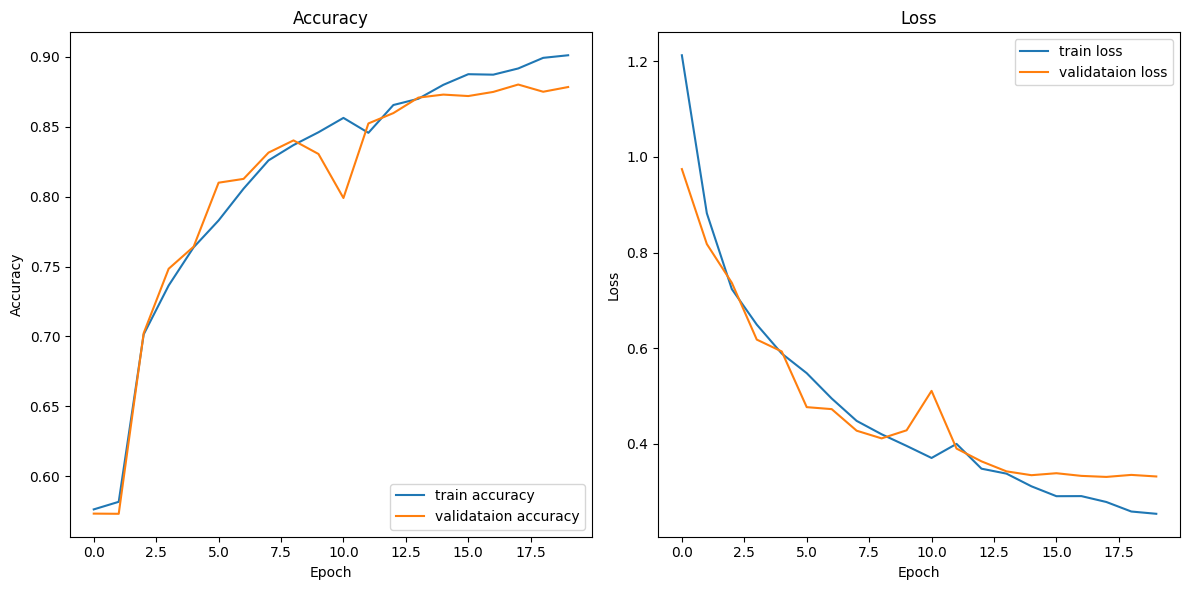

In [25]:
display_learning_curves(model.history)

## Results

In [26]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
    plt.show()

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])

number of batches: 11
2/2 [==============================] - 0s 162ms/step


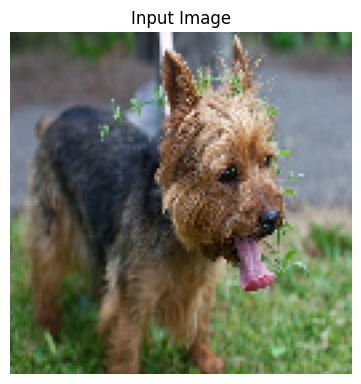

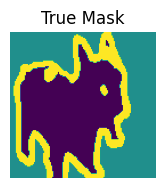

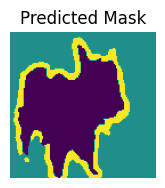

2/2 [==============================] - 0s 99ms/step


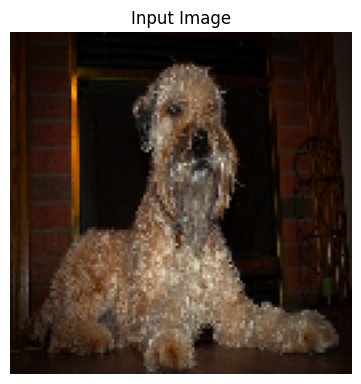

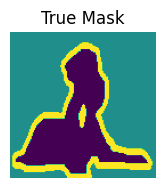

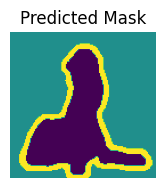

2/2 [==============================] - 0s 103ms/step


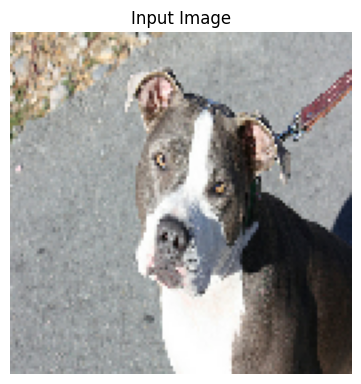

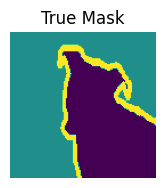

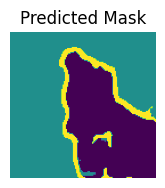

In [27]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

show_predictions(test_batches.skip(5), 3)